In [1]:
!pip install -q keras
import keras

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
from keras.models import Sequential

# Importing all the required classes from numpy and keras libraries. We will be calling the methods from these classes to perform required action in our following code.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add,BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras.datasets import mnist
from keras.regularizers import l2
from keras import regularizers

from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [2]:
# Retrieve the saved best results
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Section 1 - Following Code is for viewing GradCAM without cutout


In [3]:
#loading model without cutout from google drive 
modelpath = "/content/gdrive/My Drive/EVAModel9.json"
json_file = open(modelpath,'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#model = load_weights('/content/gdrive/My Drive/Ramjee-EVA9A_10-0.81.hdf5')

W0807 04:43:16.883736 140001842579328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 04:43:16.930954 140001842579328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 04:43:16.990073 140001842579328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 04:43:16.991604 140001842579328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 04:43:16.996242 140001842

In [0]:
#loading of weights from the drive for the saved 6A assignment without cutout
loaded_model.load_weights('/content/gdrive/My Drive/Ramjee-EVA9A_100-0.83.hdf5')

In [5]:
#importing cifar 10 database from cs.toronto.edu website.
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
predicted_classes = loaded_model.predict_classes(test_features)


In [0]:
#getting incorrect prediction images
test_labels = test_labels.reshape(10000,)
incorrect = np.nonzero(predicted_classes!=test_labels)
arincorr = incorrect[0][0:50]

In [8]:
arincorr

array([ 12,  24,  33,  35,  36,  37,  42,  47,  52,  53,  57,  58,  78,
        87,  91, 100, 106, 118, 125, 128, 139, 143, 145, 147, 154, 158,
       162, 164, 165, 171, 183, 188, 192, 221, 224, 226, 228, 232, 237,
       239, 247, 257, 275, 277, 279, 287, 306, 309, 310, 312])

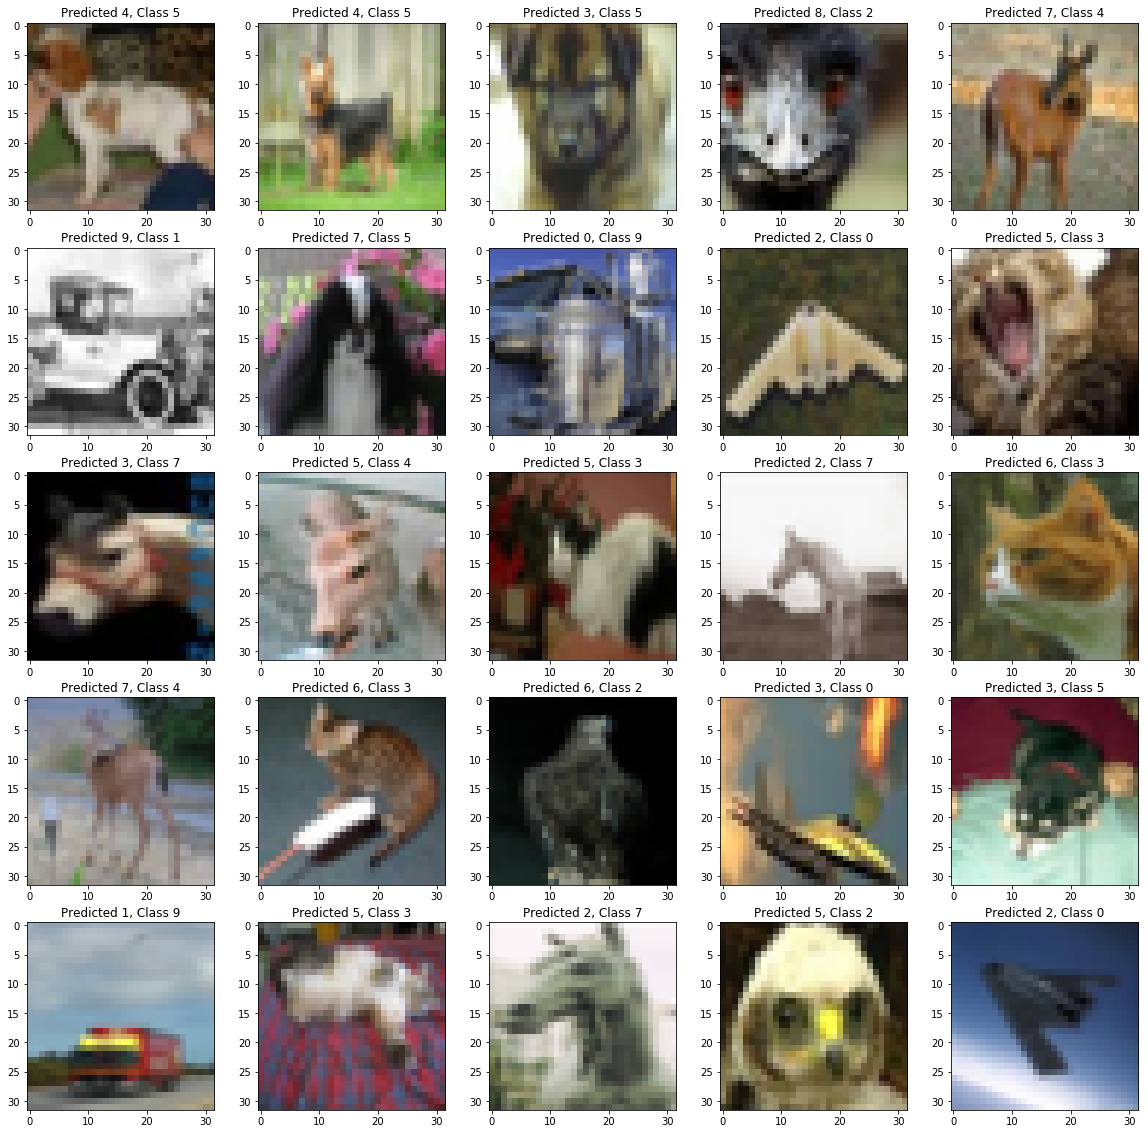

In [9]:
plt.figure(figsize = (20,20)) 
plots = []
count = 0
for i in range(5):
    for j in range(5):
        ax = plt.subplot2grid((5,5), (i,j))
        plt.imshow(test_features[arincorr[count]].reshape(32,32,3),cmap='gray',interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[arincorr[count]], test_labels[arincorr[count]]))
        count = count+1
plt.show()


In [0]:
#Taking Misclassified images
#x = [6, 9 ,27, 50, 45]
x = [12,24,33,36,47]


In [0]:

#Looping through the code for gradcam for 4 of the mis classified images and viewing the gradcam without cutout
def gradfunction(image_number):
  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
  #train_features = train_features.astype('float32')/255
  test_features = test_features.astype('float32')/255
  test_labels = np_utils.to_categorical(test_labels,10)
  img = test_features[image_number]
  process_img = image.img_to_array(img)
  process_img = np.expand_dims(process_img, axis=0)

  preds = loaded_model.predict(process_img)
  class_idx = np.argmax(preds[0])
  class_output = loaded_model.output[:, class_idx]
  last_conv_layer = loaded_model.get_layer("layer10")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([loaded_model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([process_img])
  for i in range(96):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()  
  img = test_features[image_number]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  img = cv2.resize(img, (128,128))
  superimposed_img = cv2.resize(superimposed_img, (128,128))
  
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  plt.imshow(img)
  plt.show()
  plt.imshow(superimposed_img)
  plt.show()
  cv2.waitKey(0)

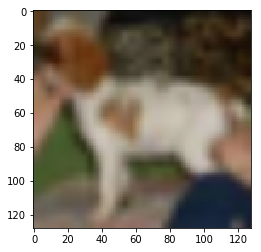

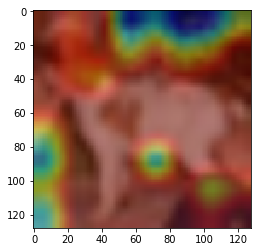

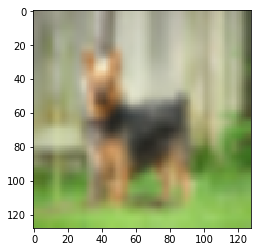

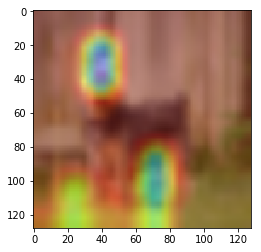

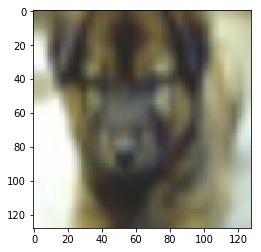

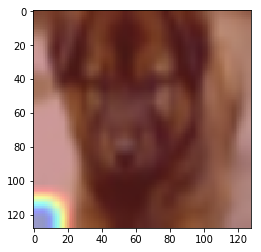

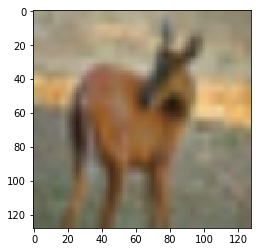

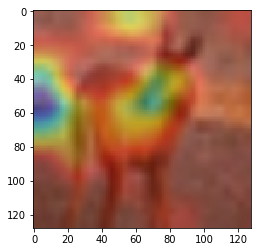

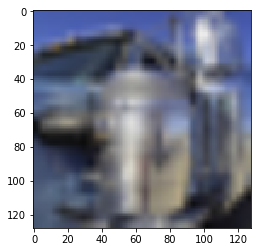

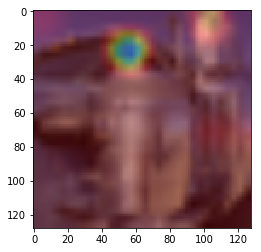

In [12]:
for n in x:
  gradfunction(n)

import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# Section 2 - Following Code is for viewing GradCAM with cutout


In [0]:
#Loading Model with cutout
modelpath = "/content/gdrive/My Drive/EVAModel9_WC.json"
json_file = open(modelpath,'r')
loaded_model_json_wc = json_file.read()
json_file.close()
loaded_model_cutout = model_from_json(loaded_model_json_wc)

#loading of weights from the drive for the saved 6A assignment with cutout


In [0]:
#loading of weights from the drive for the saved 6A assignment with cutout
loaded_model_cutout.load_weights('/content/gdrive/My Drive/Ramjee-EVA9A_WC_100-0.82.hdf5')

In [0]:
predicted_classes_wc = loaded_model_cutout.predict_classes(test_features)

In [0]:
#getting incorrect prediction images
test_labels = test_labels.reshape(10000,)
incorrect = np.nonzero(predicted_classes_wc!=test_labels)
arincorr_wc = incorrect[0][0:50]

In [17]:
arincorr_wc

array([  7,  22,  25,  32,  35,  37,  42,  52,  58,  59,  61,  70,  78,
        85, 118, 125, 128, 139, 145, 147, 164, 169, 179, 183, 184, 188,
       211, 226, 228, 237, 242, 247, 254, 263, 264, 277, 284, 303, 307,
       309, 310, 312, 323, 324, 346, 355, 370, 376, 378, 384])

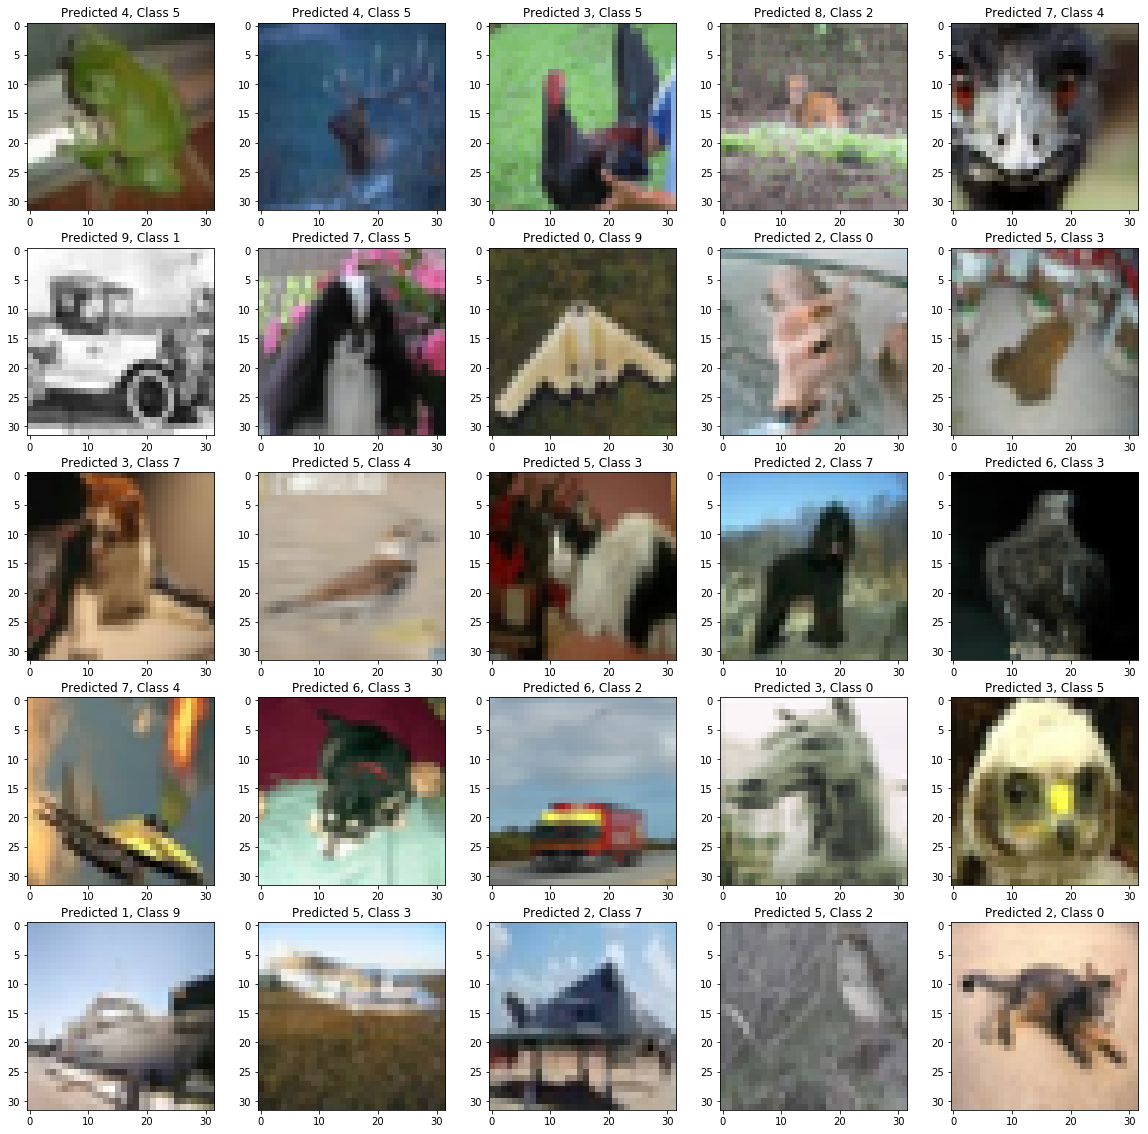

In [18]:
plt.figure(figsize = (20,20)) 
plots = []
count = 0
for i in range(5):
    for j in range(5):
        ax = plt.subplot2grid((5,5), (i,j))
        plt.imshow(test_features[arincorr_wc[count]].reshape(32,32,3),cmap='gray',interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[arincorr[count]], test_labels[arincorr[count]]))
        count = count+1
plt.show()

In [0]:
#Taking Misclassified images
#y = [6, 9 ,27, 50, 45]
y = [12,24,33,36,47]

In [0]:
#Looping through the code for gradcam for 4 of the mis classified images and viewing the gradcam without cutout
def gradfunction_wc(image_number):
  #print(test_features[1])
  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
  #train_features = train_features.astype('float32')/255
  test_features = test_features.astype('float32')/255
  test_labels = np_utils.to_categorical(test_labels,10)
  img = test_features[image_number]
  process_img = image.img_to_array(img)
  process_img = np.expand_dims(process_img, axis=0)

  preds = loaded_model_cutout.predict(process_img)
  class_idx = np.argmax(preds[0])
  class_output = loaded_model_cutout.output[:, class_idx]
  last_conv_layer = loaded_model_cutout.get_layer("layer10")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([loaded_model_cutout.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([process_img])
  for i in range(96):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()  
  img = test_features[image_number]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  img = cv2.resize(img, (128,128))
  superimposed_img = cv2.resize(superimposed_img, (128,128))
  
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  plt.imshow(img)
  plt.show()
  plt.imshow(superimposed_img)
  plt.show()
  cv2.waitKey(0)

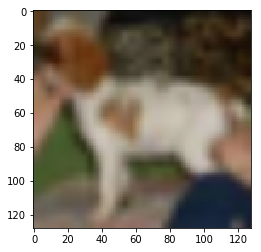

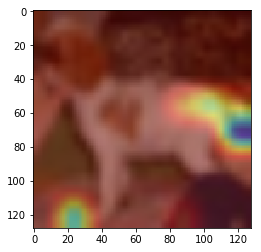

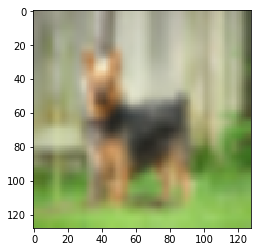

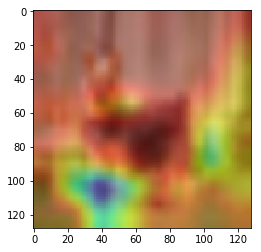

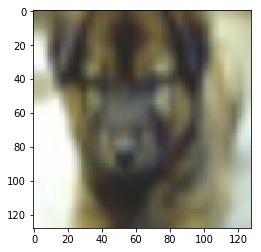

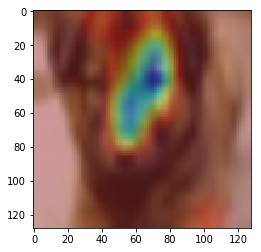

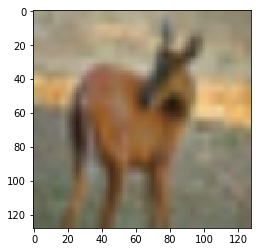

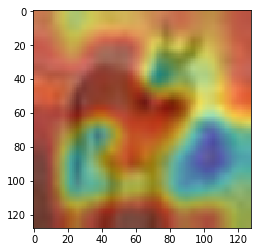

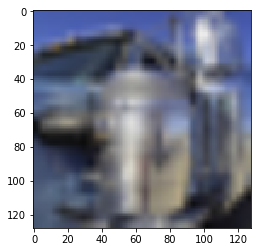

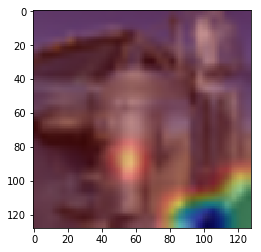

In [21]:
for n in y:
  gradfunction_wc(n)